## Notebook 2 - Operationalize Machine Learning Workflow using Hybrid ML Pipelines

##### Please ensure you have executed notebook '1_submit_pytorchdist_k8s.ipynb' before you start with this notebook

##### This notebook creates hybrid Kubeflow Pipelines that runs distributed training using either. PyTorch Training Operators on Kubernetes or Amazon SageMaker service based on conditional statements. 



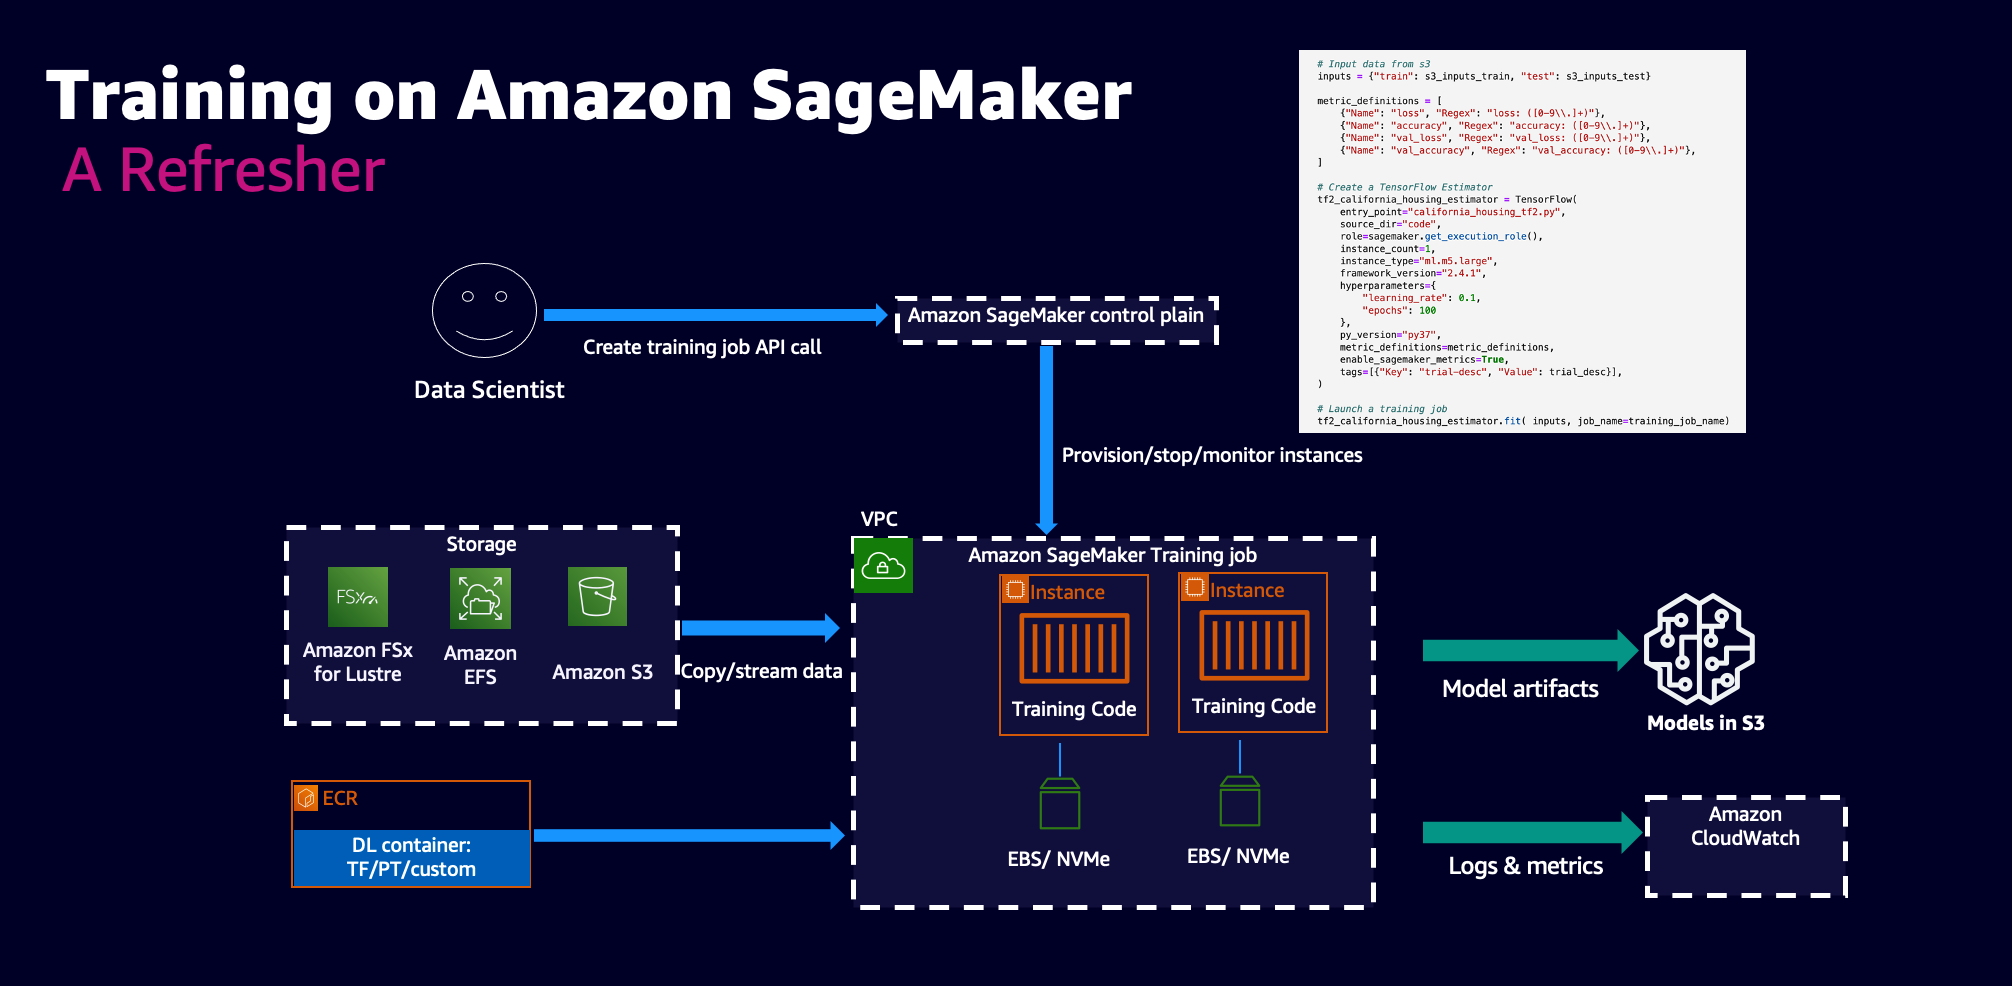

## Hybid ML Pipeline - Architecture 

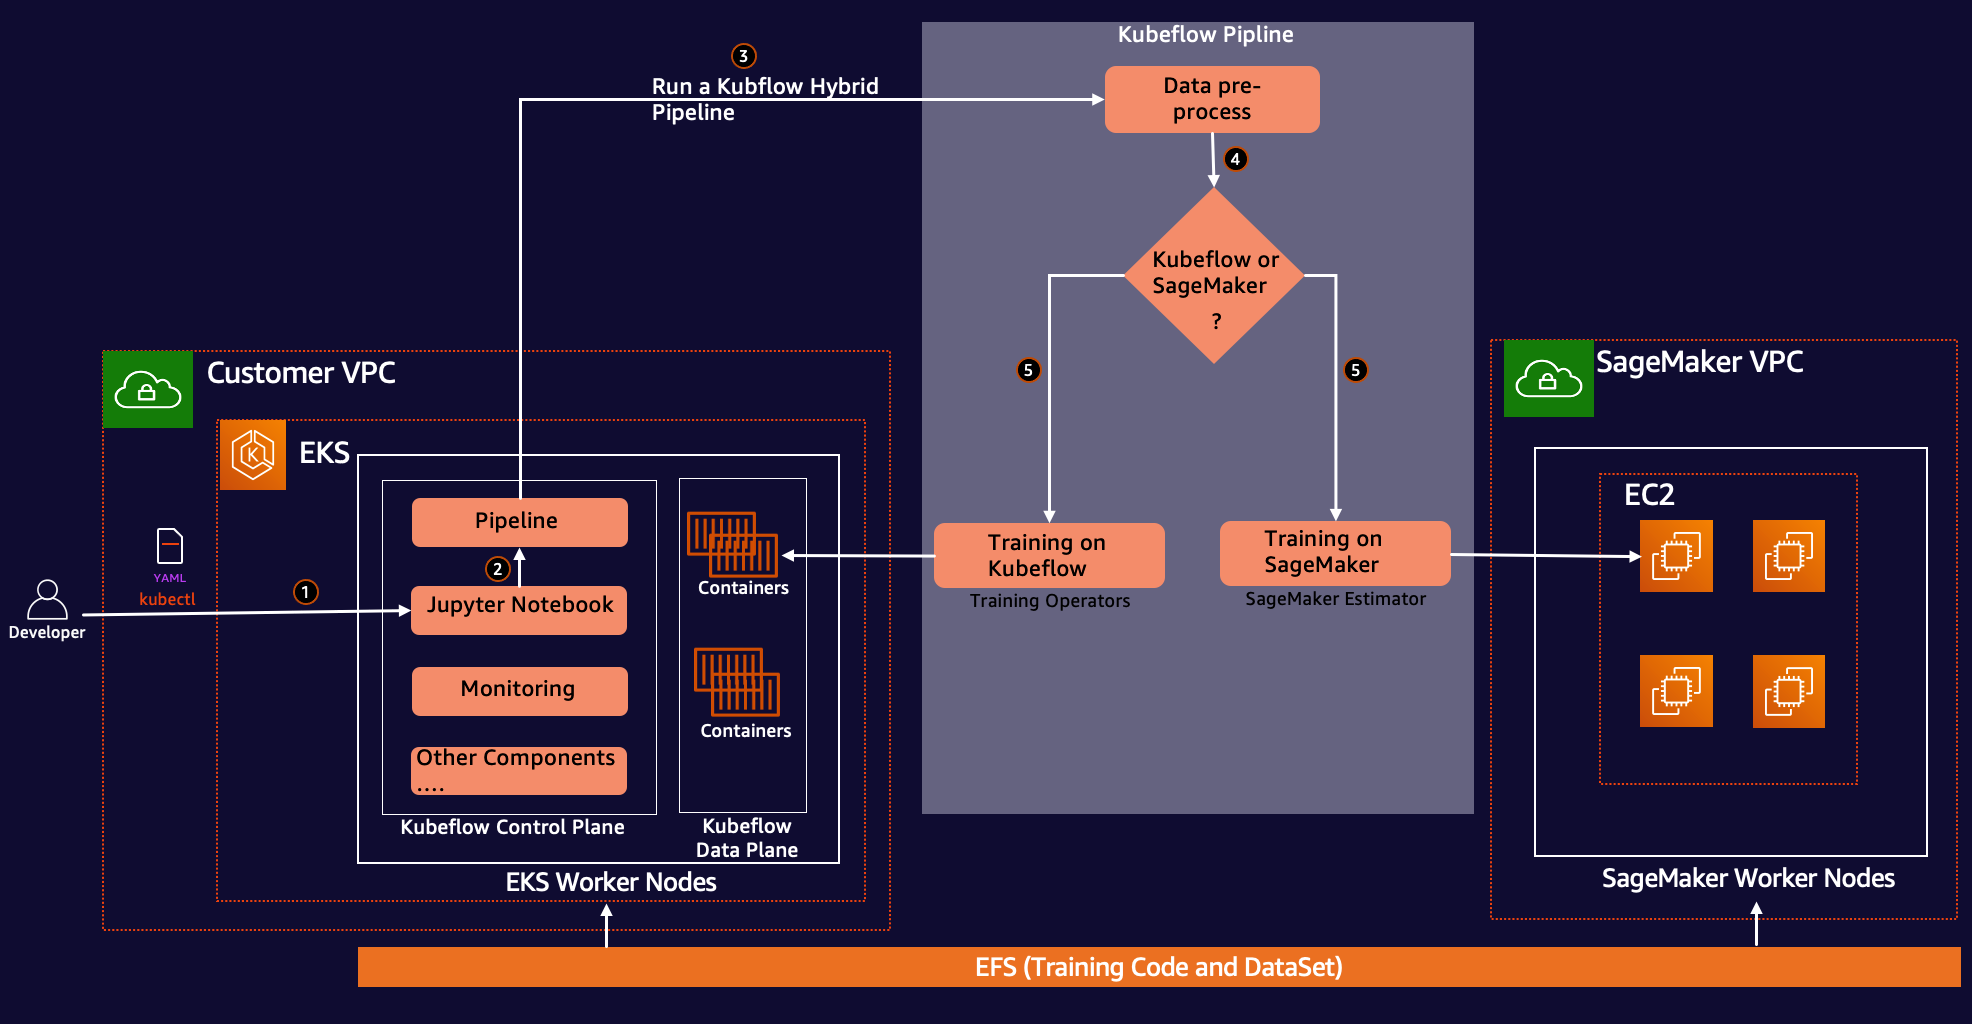

In [20]:
# Import necessary libraries 

import kfp
from kfp import components
from kubeflow.training.utils import utils
from kfp import dsl
from kfp import compiler

import os
import yaml
import json
from kubeflow.training import PyTorchJobClient
import time
import boto3
import kfp.components as comp

# Import SageMaker specific libraries
import sagemaker
import boto3
import random, string

# If you get sagemaker import error then please do 
# 1. !pip install sagemaker
# 2. restart the Kernel (Go to 'Kernel' Menu -> Click 'Restart Kernel...')

In [21]:
# Initialize global variables 

user_namespace = utils.get_default_target_namespace()

ROOT_DIR = os.path.abspath('/home/jovyan')

efs_mount_point=ROOT_DIR+'/efs-sc-claim'

aws_dlc_sagemaker_train_image='763104351884.dkr.ecr.us-west-2.amazonaws.com/pytorch-training:1.11.0-gpu-py38'

## Create SageMaker session and default bucket

In [22]:
# Get role that will be assigned to Sagemaker to call S3 apis 
sagemakerole=!aws iam get-role --role-name sagemakerrole --output text --query 'Role.Arn'

In [23]:
!aws configure set default.region 'us-west-2'

In [24]:
# Initialize SageMaker session

sess = boto3.Session()
sm= sess.client('sagemaker',region_name='us-west-2')

# Use role as shared in WorkShop Steps 
role= sagemakerole[0]
sagemaker_session = sagemaker.Session(boto_session=sess)
dataset_folder = 'datasets'

In [25]:
# SageMaker default bucket
bucket_name = sagemaker_session.default_bucket()
job_folder      = 'jobs'
dataset_folder  = 'datasets'
local_dataset = 'cifar10'
pytorchjob_name   = f'pytorch-dist-gpu-{time.strftime("%Y-%m-%d-%H-%M-%S-%j", time.gmtime())}'

bucket_name

'sagemaker-us-west-2-458473390725'

# Download the Cifar 10 dataset

In [26]:
import torchvision
cifar10_dataset = torchvision.datasets.CIFAR10(efs_mount_point+'/cifar10-dataset', 
                                     train=True, 
                                     download=True)

datasets = sagemaker_session.upload_data(path=efs_mount_point+'/cifar10-dataset', 
                                         key_prefix=f'{dataset_folder}/cifar10-dataset')

#datasets

Files already downloaded and verified


## Set up SageMaker Component Training Job

In [27]:
# Get kuberenetes pvc claim id for the provisioned efs from Kubeflow Volumes on the dashboard. eg. efs-sc-claim

pvc_claim_id=!(kubectl get pvc --no-headers=true | awk '/efs-sc-claim/{print$3}' )

pvc_claim_id[0]

'pvc-e4bc21b3-bbe8-4b16-b340-c78531ec624a'

In [28]:
efs_fs_id=!kubectl describe pv $pvc_claim_id   | awk '/VolumeHandle/{print $2}' | cut -d':' -f1

efs_fs_id[0]

'fs-013defbcf66923176'

In [29]:
# Get Subnet Id and Security Group for the EFS Mounted on your VPC Subnet

client = boto3.client('efs')

# Previous cell pre-populates File System Id. Please log in to AWS console and go to EFS service home page to verify it
file_system_id=efs_fs_id[0]
file_system_dir_path="/"+pvc_claim_id[0]+"/cifar10-dataset"

efs_mount_target_resp = client.describe_mount_targets(
    MaxItems=123,
    FileSystemId=file_system_id
)

subnet_id = efs_mount_target_resp['MountTargets'][1]['SubnetId']

subnet_id

'subnet-0778108d89d744d68'

In [30]:
subnet_id_2 = efs_mount_target_resp['MountTargets'][0]['SubnetId']
subnet_id_3 = efs_mount_target_resp['MountTargets'][2]['SubnetId']

print("Subnet ids to try for in case of capacity errors. {} and {}".format(subnet_id_2, subnet_id_3))

Subnet ids to try for in case of capacity errors. subnet-06249384da1c5d796 and subnet-08cd17a4b7aca42f8


In [31]:
import boto3

client = boto3.client('eks')

response = client.describe_cluster(
    name='eks-kubeflow'
)
security_group_id=response['cluster']['resourcesVpcConfig']['clusterSecurityGroupId']
security_group_id

'sg-0b442b6903ca005f8'

In [32]:
# Loads SageMaker components for Kubeflow pipeline from the URL

sagemaker_hpo_op = components.load_component_from_url('https://raw.githubusercontent.com/kubeflow/pipelines/cb36f87b727df0578f4c1e3fe9c24a30bb59e5a2/components/aws/sagemaker/hyperparameter_tuning/component.yaml')
sagemaker_train_op = components.load_component_from_url('https://raw.githubusercontent.com/kubeflow/pipelines/cb36f87b727df0578f4c1e3fe9c24a30bb59e5a2/components/aws/sagemaker/train/component.yaml')
sagemaker_model_op = components.load_component_from_url('https://raw.githubusercontent.com/kubeflow/pipelines/cb36f87b727df0578f4c1e3fe9c24a30bb59e5a2/components/aws/sagemaker/model/component.yaml')
sagemaker_deploy_op = components.load_component_from_url('https://raw.githubusercontent.com/kubeflow/pipelines/cb36f87b727df0578f4c1e3fe9c24a30bb59e5a2/components/aws/sagemaker/deploy/component.yaml')

In [33]:
# Upload the training script to the S3 bucket to be accessed by SageMaker training job

!tar cvfz sourcedir.tar.gz --exclude='./cifar10-dataset' --exclude='./*ipynb*' --exclude='./*pth*' -C $efs_mount_point .
source_s3 = sagemaker_session.upload_data(path='sourcedir.tar.gz', key_prefix='training-scripts')
print('\nUploaded to S3 location:')
print(source_s3)

./
./track1data/
./track1data/track1data/
./track1data/track1data/driving_log.csv
./track1data/track1data/IMG/
./track1data/track1data/IMG/center_2019_04_02_19_36_55_503.jpg
./track1data/track1data/IMG/left_2019_04_02_19_26_53_377.jpg
./track1data/track1data/IMG/center_2019_04_02_19_29_44_224.jpg
./track1data/track1data/IMG/center_2019_04_02_19_31_50_020.jpg
./track1data/track1data/IMG/left_2019_04_02_19_29_11_848.jpg
./track1data/track1data/IMG/left_2019_04_02_19_27_26_970.jpg
./track1data/track1data/IMG/right_2019_04_02_19_37_19_307.jpg
./track1data/track1data/IMG/right_2019_04_02_19_34_50_279.jpg
./track1data/track1data/IMG/right_2019_04_02_19_28_50_870.jpg
./track1data/track1data/IMG/left_2019_04_02_19_36_56_418.jpg
./track1data/track1data/IMG/right_2019_04_02_19_34_53_717.jpg
./track1data/track1data/IMG/left_2019_04_02_19_37_46_157.jpg
./track1data/track1data/IMG/right_2019_04_02_19_26_48_424.jpg
./track1data/track1data/IMG/left_2019_04_02_19_31_29_396.jpg
./track1data/track1data/

# Set up PyTorch Operator Training Job

In [34]:
# Read PyTorch Operator master and worker from the YAML file
# Pipeline specs are created in notebook '1_submit_pytorchdist_k8s.ipynb'. Please ensure you have run it.  Alternatively, you can create the specs manually. 

with open("pipeline_yaml_specifications/pipeline_master_spec.yml", 'r') as master_stream:
    master_spec_loaded = yaml.safe_load(master_stream)
    
with open("pipeline_yaml_specifications/pipeline_worker_spec.yml", 'r') as worker_stream:
    worker_spec_loaded = yaml.safe_load(worker_stream)

In [36]:
# Loads PyTorch Training Operator component from the File

pytorch_job_op = components.load_component_from_file('pipeline_components/pytorch_component.yaml')

unix_model_layout_op = components.load_component_from_file('pipeline_components/kserve_layout_component.yaml')
kserve_op = components.load_component_from_url('https://raw.githubusercontent.com/kubeflow/pipelines/master/components/kserve/component.yaml')

In [39]:
# Define a function to check if the runtime passed to a pipeline is sagemaker or kubernetes
def check_the_condition(training_runtime: str="sagemaker") -> str:
    if training_runtime.lower() == "sagemaker":
        return "sagemaker"
    elif training_runtime.lower() == "kubernetes":
        return "kubernetes"
        
    return ""

In [40]:
# Create Python function-based components for Kubeflow Pipeline

check_condition_op = comp.func_to_container_op(check_the_condition)

# Create hybrid Kubeflow Pipeline

In [41]:
# Create job name for tracking kuberenets PyTorchJob custom resource or SageMaker training job
pytorch_distributed_jobname=f'pytorch-cnn-dist-job-{time.strftime("%Y-%m-%d-%H-%M-%S-%j", time.gmtime())}'

# Define your training runtime value with either 'sagemaker' or 'kubernetes'
training_runtime='kubernetes'

# Same bucket name that we used in notebook 1_submit_pytorchdist_k8s.ipynb
kserve_s3_bucket_name='kserve-model-20230526045744'

# Create Hybrid Pipeline using Kubeflow PyTorch Training Operators and Amazon SageMaker Service
@dsl.pipeline(name="PyTorch Training pipeline", description="Sample training job test")
def pytorch_cnn_pipeline(action='apply',
                           model_name="image-classify",
                           model_uri=f's3://{kserve_s3_bucket_name}',
                           framework='pytorch',
                           region='us-west-2',
                           training_input_mode='File',
                           namespace=user_namespace,
                           train_image=aws_dlc_sagemaker_train_image,
                           volume_size='54',
                           max_run_time='86400',
                           learning_rate='0.01',
                           pytorch_backend='gloo',
                           training_job_name=pytorch_distributed_jobname, 
                           instance_type='ml.p3.2xlarge',
                           instance_count='2',
                           network_isolation='False',
                           traffic_encryption='False',
                           spot_instance='False',
                           training_runtime=training_runtime, 
                           channels='[ \
                            { \
                                "ChannelName": "train", \
                                "DataSource": { \
                                    "FileSystemDataSource": { \
                                        "FileSystemId": "'+file_system_id+'", \
                                        "FileSystemType": "EFS", \
                                        "FileSystemAccessMode": "ro", \
                                        "DirectoryPath": "'+file_system_dir_path+'" \
                                    } \
                                }, \
                                "CompressionType": "None", \
                                "RecordWrapperType": "None" \
                            } \
                         ]'
                        ):
    
    # Step to evaluate the condition. You can enter any logic here. For demonstration we are checking if GPU is needed for training 
    condition_result = check_condition_op(training_runtime)
    
    # Step to run training on Kuberentes using PyTorch Training Operators. This will be executed if gpus are not needed
    with dsl.Condition(condition_result.output == 'kubernetes', name="PyTorch_Comp"):
        train_task = pytorch_job_op(
            name=training_job_name, 
            namespace=user_namespace, 
            master_spec=json.dumps(master_spec_loaded), # Please refer file at pipeline_yaml_specifications/pipeline_master_spec.yml
            worker_spec=json.dumps(worker_spec_loaded), # Please refer file at pipeline_yaml_specifications/pipeline_worker_spec.yml
            delete_after_done=False
        ).after(condition_result)
        
        unix_model_layout=unix_model_layout_op(
            bucket=bucket_name, 
            model_input='model_kserve.pth', 
            model_archive_name='cifar').after(train_task)
    
        kserve_deploy=kserve_op(action=action,
              model_name=model_name,
              model_uri=model_uri,
              namespace=namespace,
              framework=framework).after(unix_model_layout)
    
    # Step to run training on SageMaker using SageMaker Components for Pipeline. This will be executed if gpus are needed 
    with dsl.Condition(condition_result.output == 'sagemaker', name="SageMaker_Comp"):
        training = sagemaker_train_op(
            region=region,
            image=train_image,
            job_name=training_job_name,
            training_input_mode=training_input_mode,
            hyperparameters='{ \
                "backend": "'+str(pytorch_backend)+'", \
                "batch-size": "64", \
                "epochs": "3", \
                "lr": "'+str(learning_rate)+'", \
                "model-type": "custom", \
                "sagemaker_container_log_level": "20", \
                "sagemaker_program": "cifar10-distributed-gpu-final.py", \
                "sagemaker_region": "us-west-2", \
                "sagemaker_submit_directory": "'+source_s3+'" \
            }',
            channels=channels,
            instance_type=instance_type,
            instance_count=instance_count,
            volume_size=volume_size,
            max_run_time=max_run_time,
            model_artifact_path=f's3://{bucket_name}/jobs',
            network_isolation=network_isolation,
            traffic_encryption=traffic_encryption,
            role=role,
            vpc_subnets=subnet_id, # For runtime 'sagemaker', please try subnet_id_2 and subnet_id_3 in case you receive ml.p3.2xlarge capacity errors in subnet_id
            vpc_security_group_ids=security_group_id
        ).after(condition_result)
        
    #Disable pipeline cache 
    train_task.execution_options.caching_strategy.max_cache_staleness = "P0D"
    condition_result.execution_options.caching_strategy.max_cache_staleness = "P0D"
    unix_model_layout.execution_options.caching_strategy.max_cache_staleness = "P0D"
    kserve_deploy.execution_options.caching_strategy.max_cache_staleness = "P0D"

# Compile the pipeline

In [42]:
# DSL Compiler that compiles pipeline functions into workflow yaml.

kfp.compiler.Compiler().compile(pytorch_cnn_pipeline, "pytorch_cnn_pipeline.yaml")

# Execute the Pipeline using Kubeflow Pipeline Client

In [43]:
# Connect to Kubeflow Pipelines using the Kubeflow Pipelines SDK client
client = kfp.Client()

experiment = client.create_experiment(name="kubeflow")

# Run a specified pipeline 
my_run = client.run_pipeline(experiment.id, "pytorch_cnn_pipeline", "pytorch_cnn_pipeline.yaml")

# Please click “Run details” link generated below this cell to view your pipeline. You can click every pipeline step to see logs. 

##### Useful Commands to run on Kubernetes control plane if you are running with runtime 'kubernetes'. Substitute your pod names
#####  !kubectl get pods -n kubeflow-user-example-com  
#####  !kubectl logs <pod-name> -n kubeflow-user-example-com" -f

# CleanUp

In [13]:
# Delete all previously submitted pipelines through this command. You can run in notebook as well on kubernetes cli 

#!kubectl get pods --no-headers=true  | awk '/pytorch-training-pipeline/{print $1}' | xargs  kubectl delete pod

error: resource(s) were provided, but no name was specified


In [14]:
# Delete all previously submitted PyTorchJobs through this command. You can run in notebook as well on kubernetes cli 

#!kubectl get pytorchjob --no-headers=true -A | awk '/pytorch-cnn-dist/{print $2}' | xargs  kubectl delete pytorchjob               

pytorchjob.kubeflow.org "pytorch-cnn-dist-job-2023-05-26-05-11-35-146" deleted
